# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import check_random_state
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from matplotlib import rcParams
from matplotlib import rc
from set_valued import transform_set_val, transform_set_val_conformal

# Latex + matplotlib style setup

<IPython.core.display.Javascript object>


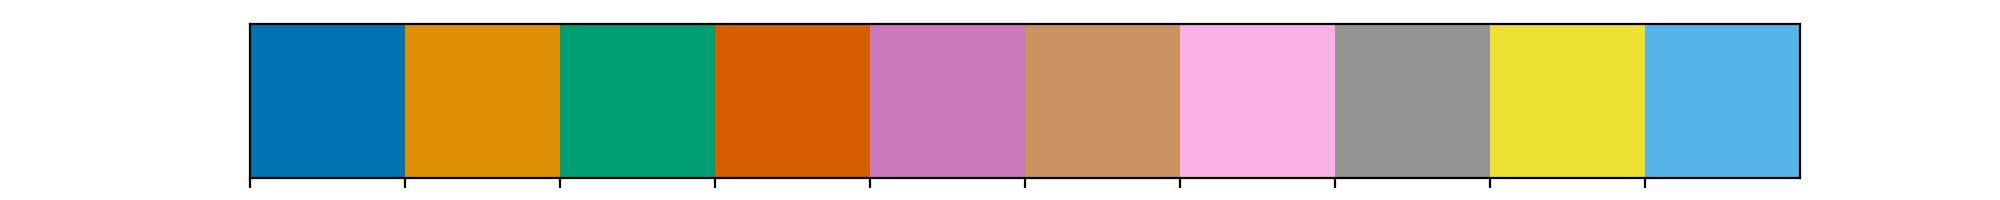

In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rcParams['text.usetex'] = True
plt.rc('text.latex',
       preamble=r'\usepackage{amsmath, amssymb}\DeclareMathOperator{\err}{P}\DeclareMathOperator{\size}{S}')


params = {'text.usetex' : True,
          'font.size' : 13,
          'text.latex.unicode': True,
          }
plt.rcParams["mathtext.fontset"] = 'dejavusans'
%matplotlib notebook
a = sns.color_palette("colorblind")
sns.palplot(sns.color_palette("colorblind"))

# Matrics 

In [3]:
def error(Y_true, Y_pred):
    n = len(Y_true)
    err = 0
    for k in range(n):
        if not Y_pred[k, int(Y_true[k])]:
            err += 1
    return err / n

def size(Y_pred):
    return np.mean(np.sum(Y_pred, axis=1))

# Load data

In [5]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Manipulations with the base classifier + initial data split

In [6]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

train_samples = 1000
test_sample = 10000
X_train, X_test_init, y_train, y_test_init = train_test_split(X, y, train_size=train_samples,
                                                              test_size=test_sample)

# clf = LogisticRegression(C=50. / train_samples, penalty='l1',
#                          solver='saga', tol=0.1)

N_unlab_max = 300
permutation = random_state.permutation(X_test_init.shape[0])
X_unlab = X_test_init[permutation[:9000]]
X_test = X_test_init[permutation[9000:test_sample]]
y_test = y_test_init[permutation[9000:test_sample]]

method = 'RF'
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy of single-output {} is {}'.format(method, score))

Accuracy of single-output RF is 0.908


# Set valued classifiers

In [7]:
num_rep = 30
s = 2
step = 10
init = 10
verbose = False
timeit = True
N_sizes = np.array(range(init, N_unlab_max + 1, step))
errors = np.zeros((num_rep, len(N_sizes)))
sizes = np.zeros((num_rep, len(N_sizes)))
score_single = 0

errors_noisy = np.zeros((num_rep, len(N_sizes)))
sizes_noisy = np.zeros((num_rep, len(N_sizes)))
print('-------- s = {} --------'.format(s))
for i in range(num_rep):
    print('-------- Iteration number {} out of {} --------'.format(i+1, num_rep))
    t0 = time.time()
    set_val = transform_set_val(clf)
    set_val_noisy = transform_set_val(clf)
    score_single += clf.score(X_test, y_test)
    random_state = check_random_state(i)
    permutation = random_state.permutation(X_test_init.shape[0])
    X_unlab = X_test_init[permutation[:9000]]
#     X_test = X_test_init[permutation[9000:test_sample]]
#     y_test = y_test_init[permutation[9000:test_sample]]
    for j, N in enumerate(N_sizes):
        permutation = random_state.permutation(X_unlab.shape[0])
        set_val.fit(X_unlab[permutation[:N]])
        set_val_noisy.fit(X_unlab[permutation[:N]], sigma=1e-6)
        Y_pred = set_val.predict(X_test, s=s)
        Y_pred_noisy = set_val_noisy.predict(X_test, s=s)
        errors[i, j] = error(y_test, Y_pred)
        sizes[i, j] = size(Y_pred)
        errors_noisy[i, j] = error(y_test, Y_pred_noisy)
        sizes_noisy[i, j] = size(Y_pred_noisy)
        if verbose:
            print("(Noiseless) N = {}".format(N),
                  "Error:".format(s), error(y_test, Y_pred),
                  'Expected size:', size(Y_pred))
            print("(Noisy) N = {}".format(N),
                  "Error:".format(s), error(y_test, Y_pred_noisy),
                  'Expected size:', size(Y_pred_noisy))
    if timeit:
        print('Finished in {0:0.3f} sec'.format(time.time() - t0))

print('Accuracy of single-output {} is {}'.format(method, score_single / num_rep))
exp_sign = '{}_{}_{}_{}_{}'.format(init, step, N_unlab_max, num_rep, s)

-------- s = 2 --------
-------- Iteration number 1 out of 30 --------
Finished in 6.087 sec
-------- Iteration number 2 out of 30 --------
Finished in 6.544 sec
-------- Iteration number 3 out of 30 --------
Finished in 6.059 sec
-------- Iteration number 4 out of 30 --------
Finished in 5.787 sec
-------- Iteration number 5 out of 30 --------
Finished in 6.106 sec
-------- Iteration number 6 out of 30 --------
Finished in 6.679 sec
-------- Iteration number 7 out of 30 --------
Finished in 6.329 sec
-------- Iteration number 8 out of 30 --------
Finished in 6.253 sec
-------- Iteration number 9 out of 30 --------
Finished in 5.982 sec
-------- Iteration number 10 out of 30 --------
Finished in 5.691 sec
-------- Iteration number 11 out of 30 --------
Finished in 5.862 sec
-------- Iteration number 12 out of 30 --------
Finished in 6.071 sec
-------- Iteration number 13 out of 30 --------
Finished in 6.830 sec
-------- Iteration number 14 out of 30 --------
Finished in 5.889 sec
-----

<IPython.core.display.Javascript object>


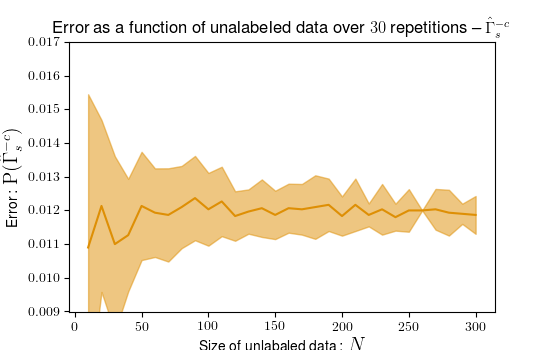

<IPython.core.display.Javascript object>


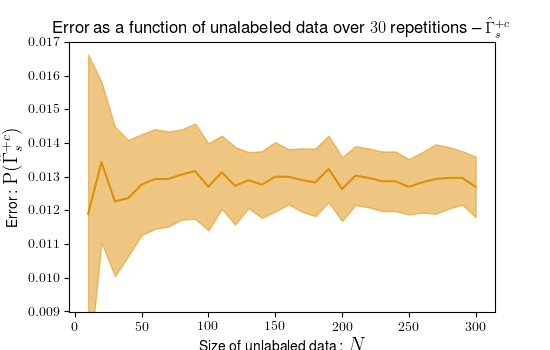

<IPython.core.display.Javascript object>


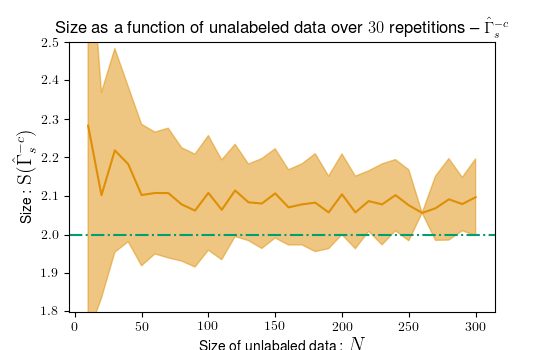

<IPython.core.display.Javascript object>


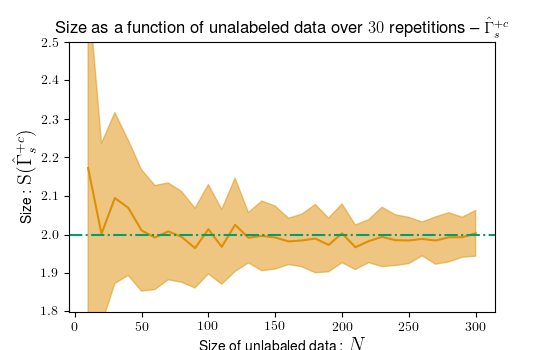

In [10]:
def get_plot_matrix(N_sizes, matr, title='Error', ylab='error', whichone='Error'):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    ax.fill_between(N_sizes, np.mean(matr, axis=0) - np.sqrt(np.var(matr, axis=0)),
                     np.mean(matr, axis=0) + np.sqrt(np.var(matr, axis=0)), alpha=0.5, color=a[1])
    ax.plot(N_sizes, np.mean(matr, axis=0), color=a[1])
    ax.set_ylabel(ylab)
    ax.set_xlabel('Size of unlabaled data : \Large$N$')
    ax.set_title(title)
    ax.set_ylim(0.009, 0.017)
    if whichone in ['size', 'size_noisy']: 
        ax.axhline(y=2, color=a[2], linestyle='-.')
        ax.set_ylim(1.8, 2.5)
    fig.savefig('{}_{}_{}.pdf'.format(whichone, exp_sign, method), bbox_inches='tight')


ylab = r'Error : \Large$\err({\hat{\Gamma}}_s^{-c})$'
title = r'Error as a function of unalabeled data over $30$ repetitions -- ${\hat{\Gamma}}_s^{-c}$'
get_plot_matrix(N_sizes, errors, title=title, ylab=ylab, whichone='error')    


ylab = r'Error : \Large$\err({\hat{\Gamma}}_s^{+c})$'
title = r'Error as a function of unalabeled data over $30$ repetitions -- ${\hat{\Gamma}}_s^{+c}$'
get_plot_matrix(N_sizes, errors_noisy, title=title, ylab=ylab, whichone='error_noisy')    


ylab = r'Size : \Large$\size({\hat{\Gamma}}_s^{-c})$'
title = r'Size as a function of unalabeled data over $30$ repetitions -- ${\hat{\Gamma}}_s^{-c}$'
get_plot_matrix(N_sizes, sizes, title=title, ylab=ylab, whichone='size')   


ylab = r'Size : \Large$\size({\hat{\Gamma}}_s^{+c})$'
title = r'Size as a function of unalabeled data over $30$ repetitions -- ${\hat{\Gamma}}_s^{+c}$'
get_plot_matrix(N_sizes, sizes_noisy, title=title, ylab=ylab, whichone='size_noisy')
# fig, ax = plt.subplots(figsize=(5.5, 3.5))
# ax.fill_between(N_sizes, np.mean(sizes, axis=0) - np.sqrt(np.var(sizes, axis=0)),
#                  np.mean(sizes, axis=0) + np.sqrt(np.var(sizes, axis=0)), alpha=0.5, color=a[1])
# ax.plot(N_sizes, np.mean(sizes, axis=0), color=a[1])
# ax.set_xlabel('Size of unlabaled data : \Large $N$')
# ax.axhline(y=2, color=a[2], linestyle='-.')
# ax.set_title(r'Size as a function of unalabeled data over ${}$ repetitions'.format(num_rep))
# ax.set_ylabel('Size : \Large$\size(\hat\Gamma)$')
# fig.savefig('size_{}_{}'.format(exp_sign, method), bbox_inches='tight')

# Histograms 

In [36]:
def get_plot_hist(Y_pred, err, siz, s, bins, ticks, labels, ylim):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(np.sum(Y_pred, axis=1), bins=bins, color=a[1], rwidth=0.9)
    ax.set_title('\large Distribution of \Large$|{\hat{\Gamma}}_s^{+c}(X)|$' + ' \large for $s = {}$'.format(s))
    ax.text(0.7, 0.9, r'$\err({\hat{\Gamma}}_s^{+c})$'+'$={0:0.3f}$'.format(err) + r' and ' + r'$\size({\hat{\Gamma}}_s^{+c})$' + '$={0:0.3f}$'.format(siz), horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=1))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xlim(0, 11)
    ax.set_ylim(0, ylim)
    fig.savefig('hist{}_{}.pdf'.format(int(s * 10), method), bbox_inches='tight')

<IPython.core.display.Javascript object>


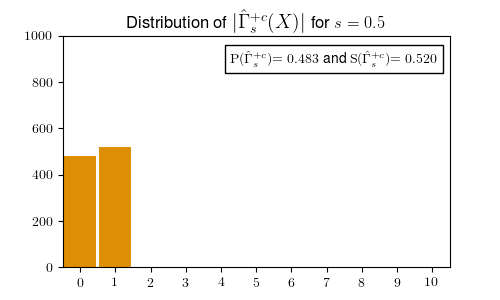

<IPython.core.display.Javascript object>


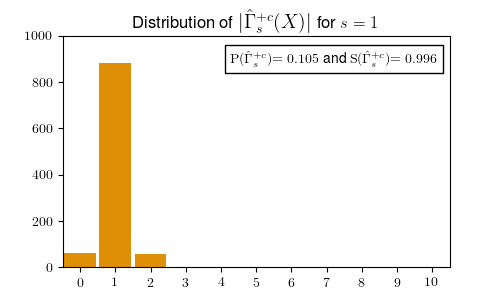

<IPython.core.display.Javascript object>


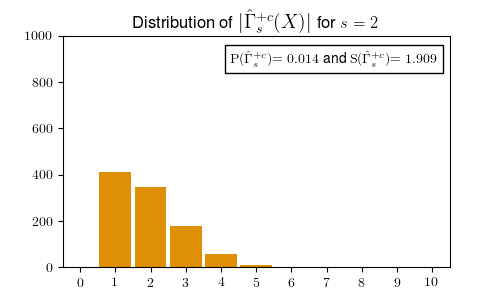

<IPython.core.display.Javascript object>


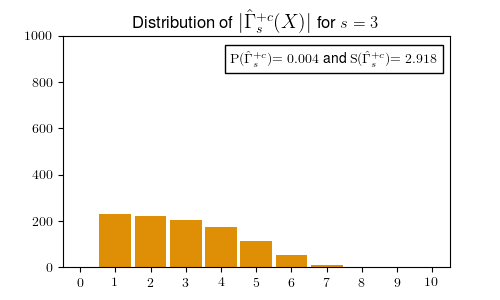

<IPython.core.display.Javascript object>


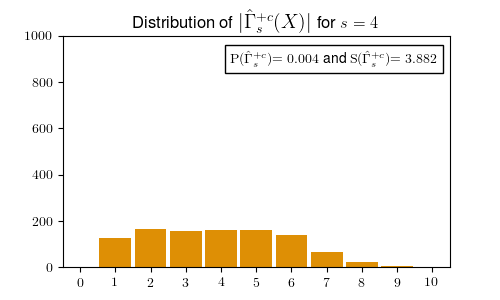

<IPython.core.display.Javascript object>


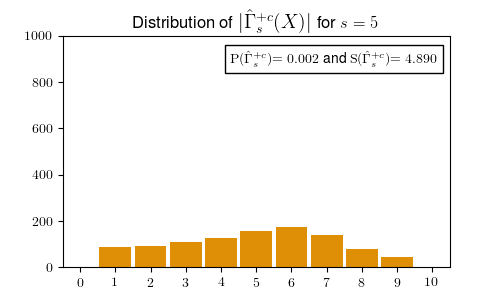

<IPython.core.display.Javascript object>


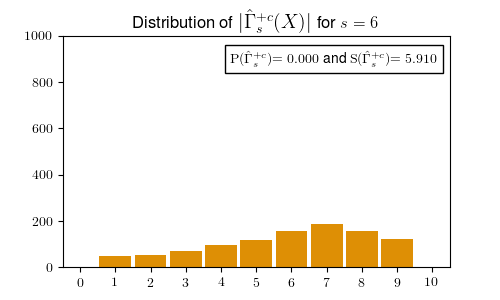

In [38]:
# random_state = check_random_state(0)
# permutation = random_state.permutation(X.shape[0])
# X = X[permutation]
# y = y[permutation]
# X = X.reshape((X.shape[0], -1))

# X_train, X_test_init, y_train, y_test_init = train_test_split(X, y, train_size=train_samples, test_size=10000)
permutation = random_state.permutation(X_test_init.shape[0])
X_unlab = X_test_init[permutation[:N_unlab_max]]
# X_test = X_test_init[permutation[N_unlab_max:]]
# y_test = y_test_init[permutation[N_unlab_max:]]
ylim = X_test.shape[0]
set_val.fit(X_unlab, sigma=1e-6)
s = 0.5
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ticks = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
labels = ['$0$', '$1$', '$2$', '$3$', '$4$','$5$', '$6$', '$7$', '$8$', '$9$', '$10$']

Y_pred = set_val.predict(X_test, s=s)
siz = size(Y_pred)
err = error(y_test, Y_pred)

get_plot_hist(Y_pred, err, siz, s, bins, ticks, labels, ylim)

for s in [1, 2, 3, 4, 5, 6]:
# for s in [1]:
    Y_pred = set_val.predict_new_s(X_test, s=s)
    err = error(y_test, Y_pred)
    siz = size(Y_pred)
    get_plot_hist(Y_pred, err, siz, s, bins, ticks, labels, ylim)

# Using same data twice or split

In [39]:
to_split = False
regimes = [True, False]
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
train_samples = 1000
N_unlab = int(0.3 * train_samples) # For splitting N = 30% of the whole training sample
num_rep = 50

s_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

errors = np.zeros((num_rep, len(s_values), 2))
sizes = np.zeros((num_rep, len(s_values), 2))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=1000)
for i in range(num_rep):
    for to_split in regimes:
        
        if to_split:
            k = 0
        else:
            k = 1
#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=1000)
        X_train, _, y_train, _ = train_test_split(X, y, train_size=train_samples, test_size=1000)
        permutation = random_state.permutation(X_train.shape[0])
        X_unlab = X_train[permutation[:N_unlab]]
        X_train_part = X_train[permutation[N_unlab:]]
        y_train_part = y_train[permutation[N_unlab:]]

#         clf = LogisticRegression(C=50. / train_samples, penalty='l1', solver='saga', tol=0.1)
        clf = RandomForestClassifier()
        if to_split:
            clf.fit(X_train_part, y_train_part)
            set_val = transform_set_val(clf)
            set_val.fit(X_unlab, sigma=1e-6)
        else:
            clf.fit(X_train, y_train)
            set_val = transform_set_val(clf)
            set_val.fit(X_train, sigma=1e-6)

        s = s_values[0]
        Y_pred = set_val.predict(X_test, s=s)
        errors[i, 0, k] = error(y_test, Y_pred)
        sizes[i, 0, k] = size(Y_pred)
        
#         print('s = ', s, 'Error: ', error(y_test, Y_pred), 'Size: ', size(Y_pred))
        for j, s in enumerate(s_values[1:]):
            Y_pred = set_val.predict_new_s(X_test, s=s)
            errors[i, j+1, k] = error(y_test, Y_pred)
            sizes[i, j+1, k] = size(Y_pred)
    print('Iteration number ', i+1, 'out of', num_rep)
#             print('s = ', s, 'Error: ', error(y_test, Y_pred), 'Size: ', size(Y_pred))
print('Done!')

Iteration number  1 out of 50
Iteration number  2 out of 50
Iteration number  3 out of 50
Iteration number  4 out of 50
Iteration number  5 out of 50
Iteration number  6 out of 50
Iteration number  7 out of 50
Iteration number  8 out of 50
Iteration number  9 out of 50
Iteration number  10 out of 50
Iteration number  11 out of 50
Iteration number  12 out of 50
Iteration number  13 out of 50
Iteration number  14 out of 50
Iteration number  15 out of 50
Iteration number  16 out of 50
Iteration number  17 out of 50
Iteration number  18 out of 50
Iteration number  19 out of 50
Iteration number  20 out of 50
Iteration number  21 out of 50
Iteration number  22 out of 50
Iteration number  23 out of 50
Iteration number  24 out of 50
Iteration number  25 out of 50
Iteration number  26 out of 50
Iteration number  27 out of 50
Iteration number  28 out of 50
Iteration number  29 out of 50
Iteration number  30 out of 50
Iteration number  31 out of 50
Iteration number  32 out of 50
Iteration number 

<IPython.core.display.Javascript object>


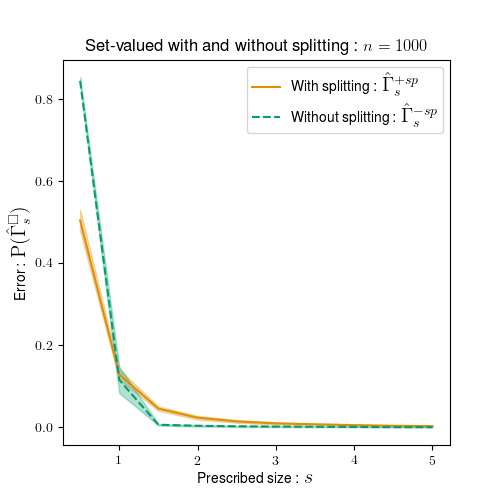

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
label1 = r'Without splitting : \Large${\hat{\Gamma}}_s^{-sp}$'
label2 = r'With splitting : \Large${\hat{\Gamma}}_s^{+sp}$'
for k in [0, 1]:
    mean_err = np.mean(errors[:, :, k], axis=0)
    var_err = np.var(errors[:, :, k], axis=0)
    if k==0:
        label = label2
        col = a[1]
        lw='-'
    else:
        label = label1
        col = a[2]
        lw='--'
    ax.fill_between(s_values, mean_err - np.sqrt(var_err),
                     mean_err + np.sqrt(var_err), alpha=0.3, color=col)
    ax.plot(s_values, mean_err, color=col, label=label, linestyle=lw)
    ax.set_ylabel(r'Error : \Large$\err({\hat{\Gamma}}_s^{\square})$')
    ax.set_xlabel('Prescribed size : \Large$s$')
    ax.set_title(r'Set-valued with and without splitting : $n={}$'.format(train_samples))
    ax.legend()
fig.savefig('error_split_{}_{}_w_noise.pdf'.format(train_samples, method), bbox_inches='tight')
    

<IPython.core.display.Javascript object>


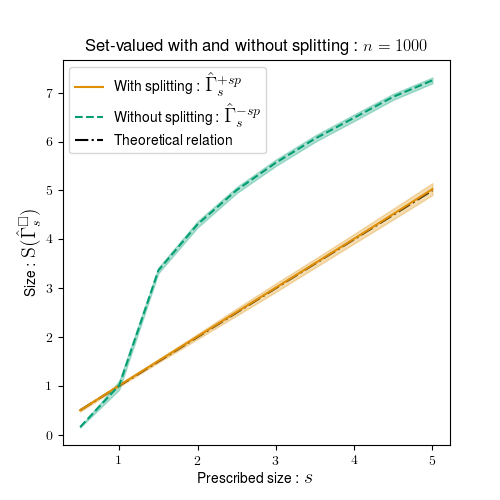

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
label1 = r'Without splitting : \Large${\hat{\Gamma}}_s^{-sp}$'
label2 = r'With splitting : \Large${\hat{\Gamma}}_s^{+sp}$'
for k in [0, 1]:
    mean_s = np.mean(sizes[:, :, k], axis=0)
    var_s = np.var(sizes[:, :, k], axis=0)
    if k==0:
        label = label2
        col = a[1]
        lw='-'
    else:
        label = label1
        col = a[2]
        lw='--'
    ax.fill_between(s_values, mean_s - np.sqrt(var_s),
                     mean_s + np.sqrt(var_s), alpha=0.3, color=col)
    ax.plot(s_values, mean_s, color=col, label=label, linestyle=lw)
    ax.set_ylabel(r'Size : \Large$\size({\hat{\Gamma}}_s^{\square})$')
    ax.set_xlabel('Prescribed size : \Large$s$')
    ax.set_title(r'Set-valued with and without splitting : $n={}$'.format(train_samples))

ax.plot(np.linspace(0.5, 5, 10), np.linspace(0.5, 5, 10), linestyle='-.', color='black',
            label=r'Theoretical relation', alpha=1, zorder=0)
ax.legend()
fig.savefig('size_split_{}_{}_w_noise.pdf'.format(train_samples, method), bbox_inches='tight')